In [2]:
import numpy as np
import pandas as pd
import time
import sklearn


readdata = pd.read_csv("C:/Users/Dom/MPhys/TheGrandTour/wine_data.txt", sep="\t", header=None);
data = np.array(readdata);
data = np.delete(data, 0, 0)
data = data.astype(float)
data = np.swapaxes(data,0,1)


# Need to seperate the classification dimension:
classification = data[13]
data = np.delete(data, 13, axis=0)


# make list of colours for each number:
data_colour = []
for i in range(len(classification)):
    if classification[i] == 1:
        data_colour.append("r")
    elif classification[i] == 2:
        data_colour.append("b")
    elif classification[i] == 3:
        data_colour.append("g")
        
# Normalizes the data        
for i in range(0, np.shape(data)[0]):
    data[i,:] = (data[i,:] / np.ndarray.max(data[i,:])) * 2 - 1
    
        


#VARIABLES
stepSize = 0.01
nSteps = 10000

def getAlpha(d):
    """
    NEEDS IMPLEMENTATION
    Should produce 1xd(d-1)/2 array of position in grand tour.
    """
    p = d*(d-1)/2     
    primeList = []
    count = 1
    while len(primeList) < p:
        count += 1
        primeBool = False
        for i in range(2, count - 1):
            if count % i == 0:
                primeBool = True
        if primeBool == False:
            irrational = (np.sqrt(count)%1)
            primeList.append(irrational)
            
    primeList = np.asarray(primeList)
    primeList = primeList.dot(stepSize)
    """
    Irrational number generation using exponentials, not being used
    p = int(d*(d-1)/2)
    alpha = np.zeros(p) #alpha(t) parameters defining grand tour in G2,d
    for i in range(0,p):
        alpha[i] = (np.exp(i) % 1) * 2 * np.pi
        
    alpha = alpha.dot(0.001)
    """
    
    
    return primeList


def getAngles(alpha,d):
    """""
    Inputs: 
    alpha = 1xd(d-1)/2 array defining position on grand tour
    d = dimensions of data
    Outputs a dxd array of angles required for the transformation
    """
    theta = np.zeros((d,d));
    i = 0;
    k = 0;
    
    while i < d-1:
        j = i + 1;
        
        while j < d:
            theta[i][j] = alpha[k];
            j += 1;
            k += 1;
    
        i+= 1;
        
    return theta;


def RotationMatrix(i, j, d, theta):
    """
    Inputs:
    i = first indicie of rotating plane
    j = second indicie of rotating plane
    d = dimensions of data
    theta = dxd array of angle of rotation of rotating plane
    Outputs a rotating matrix to rotate plane of ixj plane by theta_ij
    """
    R = np.identity(d)
    R[i,i] = np.cos(theta)
    R[i,j] = -1*np.sin(theta)
    R[j,i] = np.sin(theta)
    R[j,j] = np.cos(theta)
    return R


def BetaFn(d, theta):
    """
    Inputs:
    d = dimensions of data
    theta = dxd array of angle of rotation ixj plane
    Outputs the full matrix transformation for all rotations
    """
    b = RotationMatrix(1, 2, d, theta[1,2])
    i = 1
    j = 2
    for i in range(d):
        for j in range(d):
            if j <= i:
                continue
            if i==1 and j==2:
                continue
            b = np.matmul(b, RotationMatrix(i, j, d, theta[i,j]))
            
    return b


def GrandTour(data, nSteps):
    """
    Inputs:
    data = array of data points, dimensions x npoints
    Outputs a 3D array number of points x t x dimensions, where t
    the time step at that point in the tour
    """

    d = np.shape(data)[0] #dimensions of data
    nPoints = np.shape(data)[1] #number of data points
    tData = np.zeros((nSteps,d,nPoints)) #initialise 3d matrix to store stransforemd data at each timestep
    tBeta = np.zeros((nSteps,d,d))
    Alpha = getAlpha(d)

    
    for t in range(0, nSteps):
        
        
        alpha = Alpha.dot(t)
        theta = getAngles(alpha, d)
        b = BetaFn(d, theta)
        a = np.matmul(b, data)
        tData[t,:,:] = a
        tBeta[t,:,:] = b
        
    return tData, tBeta


tData, tBeta = GrandTour(data, nSteps)



In [ ]:
for i in range(0, 1000):
    if i % 2 == 0:
        xData = tData[i][0]
        yData = tData[i][1]

        plt.scatter(xData, yData, color = data_colour)
        plt.show()

        
#slider_depth.on_changed(update_depth)
plt.show()


<IPython.core.display.Javascript object>


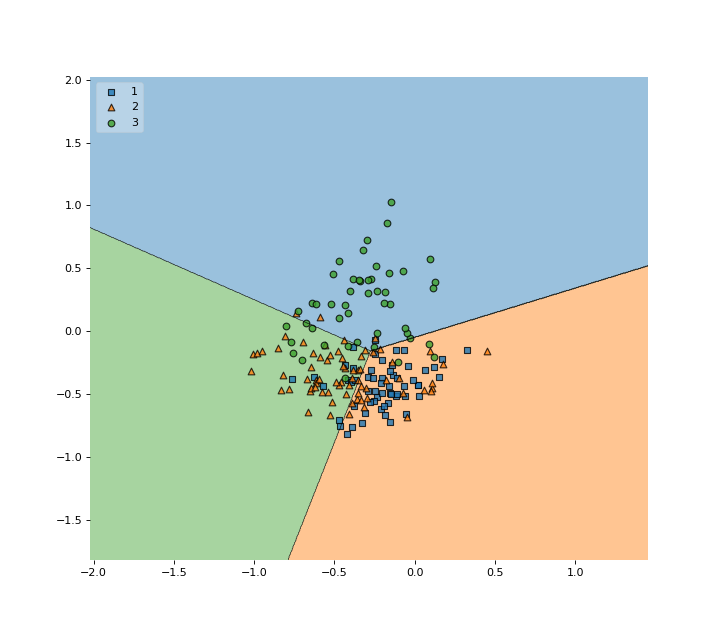

interactive(children=(FloatSlider(value=1.0, description='timestep', max=9999.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_func>

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mlxtend.plotting import plot_decision_regions

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC,LinearSVC

import matplotlib.pyplot as plt


%matplotlib inline
%matplotlib notebook

import numpy as np

fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title('SVM Decision Region Boundary', size=16)

def plot_func(timestep):
    fig.clear()
    xData = tData[int(timestep)][0]
    yData = tData[int(timestep)][1]
    nData = np.vstack((xData, yData)).T

    #plt.scatter(xData, yData, color = data_colour)
    #plt.show()
    
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    plot_decision_regions(X=nData, 
                          y=classification.astype(np.integer),
                          clf=clf, 
                          legend=2)
    print(clf.score(nData, classification))
    plt.show()
    
interact(plot_func, timestep = widgets.FloatSlider(value=1,
                                               min=0,
                                               max=9999,
                                               step=1))



<IPython.core.display.Javascript object>


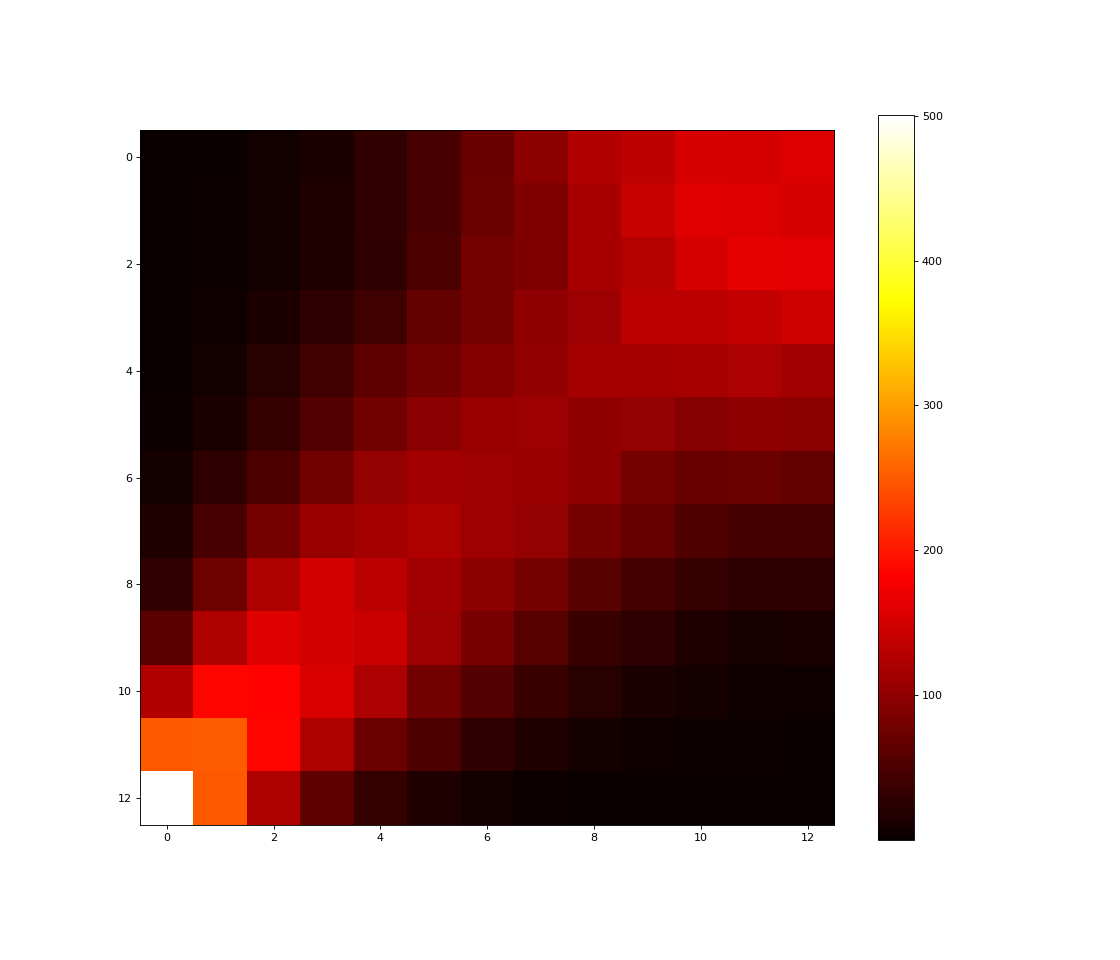

In [92]:
sumRotMatrix = np.power(tBeta[0], 2)
for i in range(1, 1000):
    sumRotMatrix = np.add(sumRotMatrix, np.power(tBeta[i], 2))
    
fig = plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(sumRotMatrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [57]:
from sklearn.svm import SVC,LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt


accuracy = []

for i in range(10000):
    xData = tData[i][0]
    yData = tData[i][1]
    nData = np.vstack((xData, yData)).T
    
    clf = OneVsRestClassifier(SVC(kernel='poly'), n_jobs=-1)
    clf.fit(nData, classification)

    score = clf.score(nData, classification)
    accuracy.append(score)


x = list(range(0, len(accuracy)))


<IPython.core.display.Javascript object>


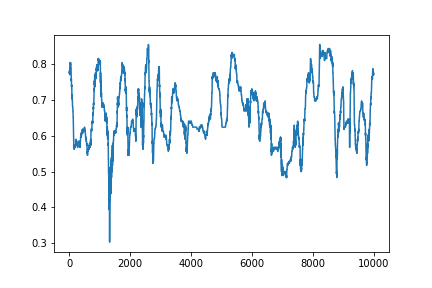

2602 0.8539325842696629


In [58]:
fig.clear()
new = plt.figure()
plt.plot(x, accuracy, "-", marker="None")

max_accuracy = max(accuracy)
acc = max_accuracy
max_accuracy = [i for i, j in enumerate(accuracy) if j == max_accuracy]
max_accuracy = max_accuracy[0]
print(max_accuracy, acc)

In [22]:
from mlxtend.plotting import plot_decision_regions

fig.clear()

xData = tData[max_accuracy][0]
yData = tData[max_accuracy][1]
nData = np.vstack((xData, yData)).T

clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
clf.fit(nData, classification)

score = clf.score(nData, classification)


plot_decision_regions(X=nData, 
                      y=classification.astype(np.integer),
                      clf=clf, 
                      legend=2)

plt.title('SVM Decision Region Boundary', size=16)
plt.show()


In [6]:
import time


distanceMatrix = np.zeros((178, 178))
oldDistanceMatrix = np.zeros((178, 178))
travelMatrix = np.zeros((178, 178))

start = time.clock()

for t in range(500):
    if t % 100 == 0:
        print(time.clock() - start)

        
    travelMatrix = np.add(travelMatrix, np.absolute(np.subtract(distanceMatrix, oldDistanceMatrix)))
    if t != 0:
        oldDistanceMatrix = distanceMatrix
        distanceMatrix = np.zeros((178, 178))
        
    for i in range(len(tData[0][0])):
        x1Data = tData[t][0][i]
        y1Data = tData[t][1][i]
        
        for j in range(len(tData[0][0])):
            if i > j:
                continue
            x2Data = tData[t][0][j]
            y2Data = tData[t][1][j]
            distance = np.sqrt(((x1Data - x2Data) ** 2) + ((y1Data - y2Data) ** 2))
            distanceMatrix[i][j] = distance

travelMatrix

0.0005437263965855002
9.497498712706788
19.248644148395368
29.27511571052021
38.868483123695384


array([[0.        , 2.95477018, 3.46267426, ..., 9.33462786, 9.28626124,
        9.37518027],
       [0.        , 0.        , 3.93326889, ..., 8.55971885, 8.4732196 ,
        8.56755161],
       [0.        , 0.        , 0.        , ..., 6.84276178, 6.94586004,
        7.84224923],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.85660742,
        2.20749031],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.42089201],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [58]:
print(travelMatrix[0])
print(classification)

[ 0.          2.95477018  3.46267426  4.01838008  4.2494209   5.16759465
  2.78957133  3.36864078  3.97759235  2.00876591  3.77690141  4.5524255
  4.42386462  6.50141035  4.36248268  5.32367153  4.92875595  5.95687841
  7.07505884  3.28036414  1.62332431  3.09397534  2.03658675  2.54659393
  2.2593713   3.93225654  3.20609247  4.43840589  2.72362853  1.72720869
  4.4784216   4.4464814   4.14301018  5.01805994  3.4624062   1.86946876
  4.81068255  4.81295779  4.25803036  3.31064113  2.13277952  4.61657381
  1.83669005  5.15552693  2.01516815  3.8585345   2.28239075  2.0067986
  4.39692306  4.45713755  4.48586902  2.5240541   2.98260887  4.99493698
  2.32109459  3.01991953  1.9672514   4.50459452  3.99470237  9.65227566
 10.37079813 10.65716996  6.33625331  4.32251941  7.69671887  5.99590174
  3.78527233  4.3438829   8.42817118  5.64423314  7.4149048   3.94403643
  5.65427271  3.44307871  3.81039439  6.98560816  6.16959041  6.79539381
  6.34287567  5.81584276  5.54440879  2.71622951  5.6

In [26]:
fig, ax = plt.subplots()

min_val, max_val = 0, 15

intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))

ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

for i in xrange(15):
    for j in xrange(15):
        c = intersection_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

array([[10.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

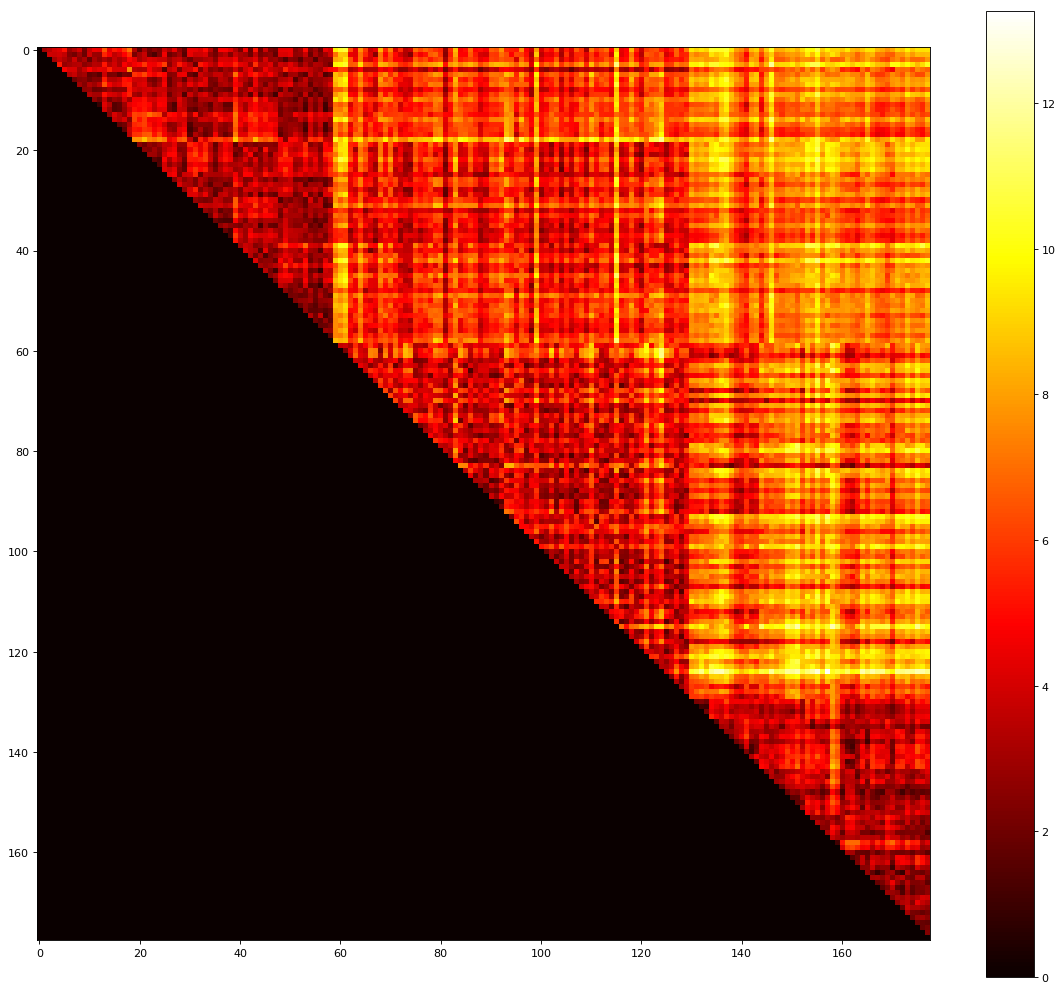

In [18]:

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(travelMatrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [20]:
travelMatrix[0]

array([ 0.        ,  2.95477018,  3.46267426,  4.01838008,  4.2494209 ,
        5.16759465,  2.78957133,  3.36864078,  3.97759235,  2.00876591,
        3.77690141,  4.5524255 ,  4.42386462,  6.50141035,  4.36248268,
        5.32367153,  4.92875595,  5.95687841,  7.07505884,  3.28036414,
        1.62332431,  3.09397534,  2.03658675,  2.54659393,  2.2593713 ,
        3.93225654,  3.20609247,  4.43840589,  2.72362853,  1.72720869,
        4.4784216 ,  4.4464814 ,  4.14301018,  5.01805994,  3.4624062 ,
        1.86946876,  4.81068255,  4.81295779,  4.25803036,  3.31064113,
        2.13277952,  4.61657381,  1.83669005,  5.15552693,  2.01516815,
        3.8585345 ,  2.28239075,  2.0067986 ,  4.39692306,  4.45713755,
        4.48586902,  2.5240541 ,  2.98260887,  4.99493698,  2.32109459,
        3.01991953,  1.9672514 ,  4.50459452,  3.99470237,  9.65227566,
       10.37079813, 10.65716996,  6.33625331,  4.32251941,  7.69671887,
        5.99590174,  3.78527233,  4.3438829 ,  8.42817118,  5.64

In [42]:
d = np.shape(travelMatrix)[0]

travelone = np.zeros((d,d))
for i in range(0,d):
    
    travelone[i][:] = np.sort(travelMatrix[i])

In [43]:
travelsum = np.sum(travelone,axis=0)

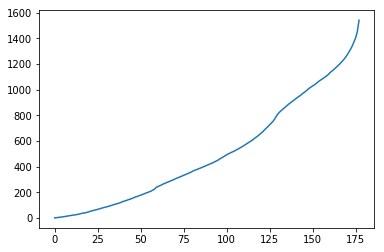

In [44]:
plt.plot(travelsum)

In [40]:
travelone = np.array((d,d))
travelone[1]

178

In [3]:
from mlxtend.plotting import plot_decision_regions


plot_decision_regions(X=X.values, 
                      y=y.values,
                      clf=clf, 
                      legend=2)


NameError: name 'X' is not defined

In [2]:
!pip install mlxtend

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [17]:
from matplotlib import animation 
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-webm;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.webm') as f:
            anim.save(f.name, fps=6, extra_args=['-vcodec', 'libvpx'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")

    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title('SVM Decision Region Boundary', size=16)

def plot_func(timestep):
    fig.clear()
    xData = tData[int(timestep)][0]
    yData = tData[int(timestep)][1]
    nData = np.vstack((xData, yData)).T

    #plt.scatter(xData, yData, color = data_colour)
    #plt.show()
    
    clf = OneVsRestClassifier(SVC(kernel='linear'), n_jobs=-1)
    clf.fit(nData, classification)
    plot_decision_regions(X=nData, 
                          y=classification.astype(np.integer),
                          clf=clf, 
                          legend=2)
    print(clf.score(nData, classification))
    plt.show()
    
    
    


def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, plot_func,
                               frames=1000, interval=20, blit=True)

FFwriter = animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
anim.save('test.mp4', writer = FFwriter)


<IPython.core.display.Javascript object>

FileNotFoundError: [WinError 2] The system cannot find the file specified